In [3]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum, avg, count, round
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

# Problem Statement 3: Product Sales Performance Evaluation

**Objective:** Evaluate the sales performance of products to identify top-selling items and assess category performance.

**Description:**
1.	Analyse transactions.csv to determine total revenue and sales volume for each product.
2.	Join with products.csv to categorize products and evaluate performance by product category.

**Expected Deliverables:**
- A detailed analysis of sales performance, identifying top-selling products and categories.
- An assessment of how pricing affects sales volume.


# Initialized Spark Session and Loaded Data into Spark Dataframe

In [4]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Product Sales Performance Evaluation") \
    .getOrCreate()

# Load data into Spark DataFrames
customers_df = spark.read.csv("Cleaned_data/cleaned_customers.csv", header=True, inferSchema=True)
transactions_df = spark.read.csv("Cleaned_data/cleaned_transactions.csv", header=True, inferSchema=True)
products_df = spark.read.csv("Cleaned_data/cleaned_products.csv", header=True, inferSchema=True)

# Validate the data
customers_df.show(5,truncate=False)
transactions_df.show(5,truncate=False)
products_df.show(5,truncate=False)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/01 11:14:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4044. Attempting port 4045.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4045. Attempting port 4046.
24/09/01 11:14:58 WARN Utils: Service 'SparkUI' could not bind on port 4046. Attempting port 4047.
24/09/01 11:14:58 WARN Utils: Serv

+------------------------------------+-----------------+----------------------+---------------+-----------+
|Customer_ID                         |Name             |Email                 |Phone          |Country    |
+------------------------------------+-----------------+----------------------+---------------+-----------+
|003ca69a-991c-4c11-899a-51bb7365499d|Erica Diaz       |hurleyanna@example.com|+964-8545044941|Iraq       |
|006af455-013b-4c09-a6df-15ca3d41010f|Jason Jackson    |dylanduran@example.com|+63-2484285464 |Philippines|
|00fc38f7-b5c7-465c-839b-a55185f2635f|Heather Schneider|larajohn@example.org  |+264-7935879728|Namibia    |
|015cc4e1-5cf8-441c-80ad-ca3536c53e9a|Matthew Wilson   |timothyho@example.org |+357-8883554148|Cyprus     |
|01d13428-d511-4c3d-90c7-b5624931ff48|Robert Contreras |lydia12@example.com   |unknown        |Swaziland  |
+------------------------------------+-----------------+----------------------+---------------+-----------+
only showing top 5 rows

+--

# Total Revenue and Sales Volume of Each Product

In [5]:
# Join the transactions DataFrame with the products DataFrame on Product_ID
merged_df = transactions_df.join(products_df, on='Product_ID')

# Calculate total revenue and sales volume for each product
product_sales_df = merged_df.groupBy("Product_ID", "Product_Name", "Category", "Price").agg(
    round(_sum("Amount"), 2).alias("Total_Revenue"),
    count("Transaction_ID").alias("Sales_Volume")
)

# Show the results
product_sales_df.show(50,truncate=False)

+----------+------------+-------------+------+-------------+------------+
|Product_ID|Product_Name|Category     |Price |Total_Revenue|Sales_Volume|
+----------+------------+-------------+------+-------------+------------+
|44        |Friend      |Home         |517.0 |5876.78      |22          |
|29        |Fear        |Clothing     |1379.0|5233.0       |16          |
|34        |Hope        |Home         |100.0 |3364.78      |16          |
|21        |Contain     |Clothing     |850.0 |6974.12      |23          |
|40        |Themselves  |Beauty       |510.0 |5296.0       |19          |
|41        |Place       |Home         |544.0 |6674.78      |26          |
|46        |Population  |Home         |1418.0|6173.0       |21          |
|35        |Support     |Electronics  |992.0 |6137.34      |23          |
|25        |Left        |Electronics  |277.0 |5397.78      |21          |
|27        |Student     |Electronics  |145.0 |7899.56      |28          |
|7         |Charge      |Home         

# 1. Total Revenue of Each Product by Category

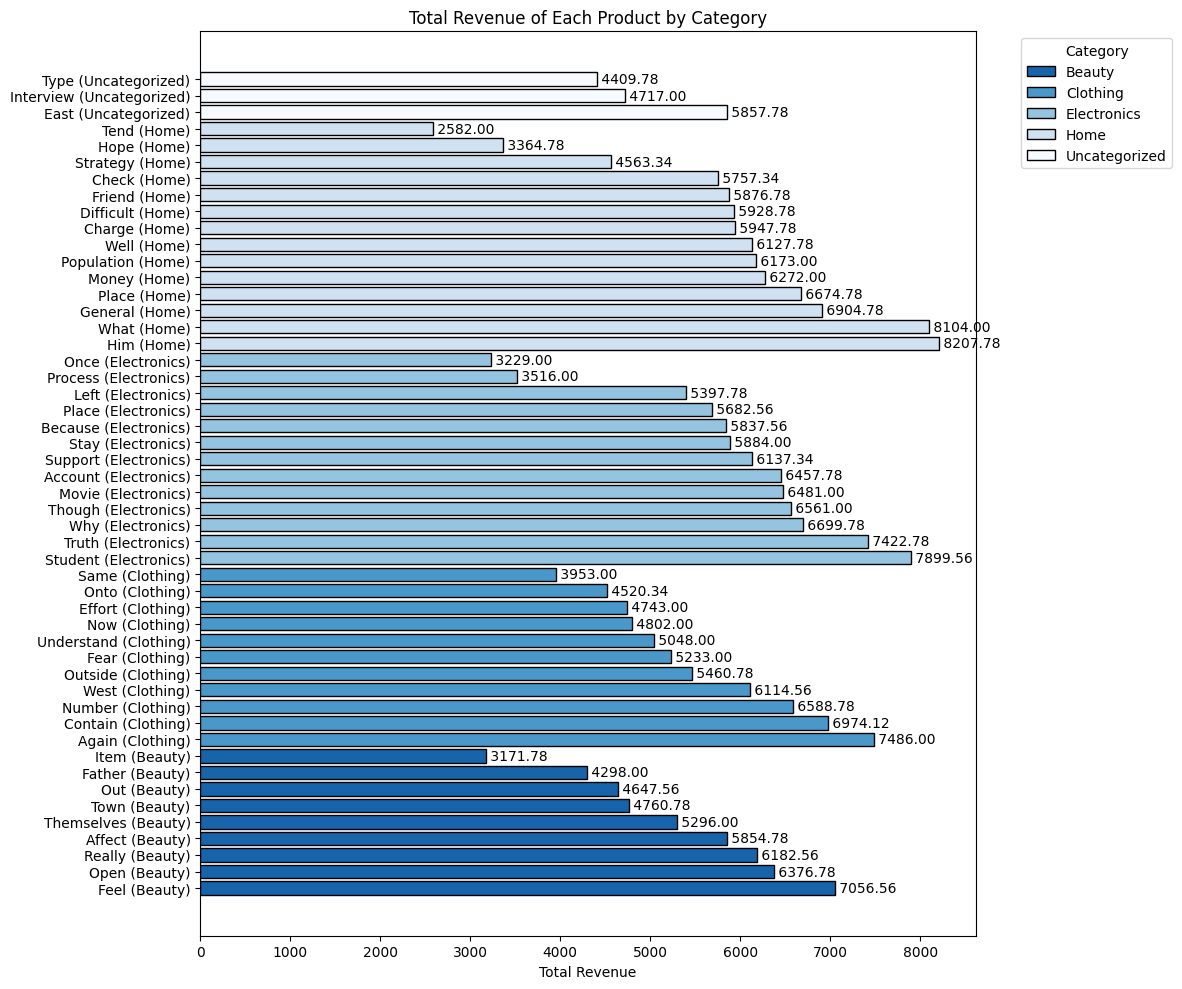

In [7]:
product_sales_df = product_sales_df.toPandas()

# Sort the DataFrame by 'Category' and then by 'Total_Revenue' within each category
product_sales_df = product_sales_df.sort_values(by=['Category', 'Total_Revenue'], ascending=[True, False])

# Add category information to product names for y-axis labels
product_sales_df['Product_Label'] = product_sales_df['Product_Name'] + ' (' + product_sales_df['Category'] + ')'

# Set up the plotting space
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique categories for color coding
categories = product_sales_df['Category'].unique()

# Define a colormap for shades of blue
cmap = get_cmap('Blues')

# Generate colors for each category
palette = [cmap(i / len(categories)) for i in range(len(categories))][::-1]

# Plot each category
for i, category in enumerate(categories):
    category_data = product_sales_df[product_sales_df['Category'] == category]
    bars = ax.barh(category_data['Product_Label'], category_data['Total_Revenue'], 
                   label=category, color=palette[i], edgecolor='black')

    # Add exact revenue labels on the bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f' {width:.2f}', 
                va='center', ha='left', fontsize=10, color='black')

# Set labels and title
ax.set_xlabel('Total Revenue')
ax.set_title('Total Revenue of Each Product by Category')
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()


# 2. Sales Volume of Each Product by Category

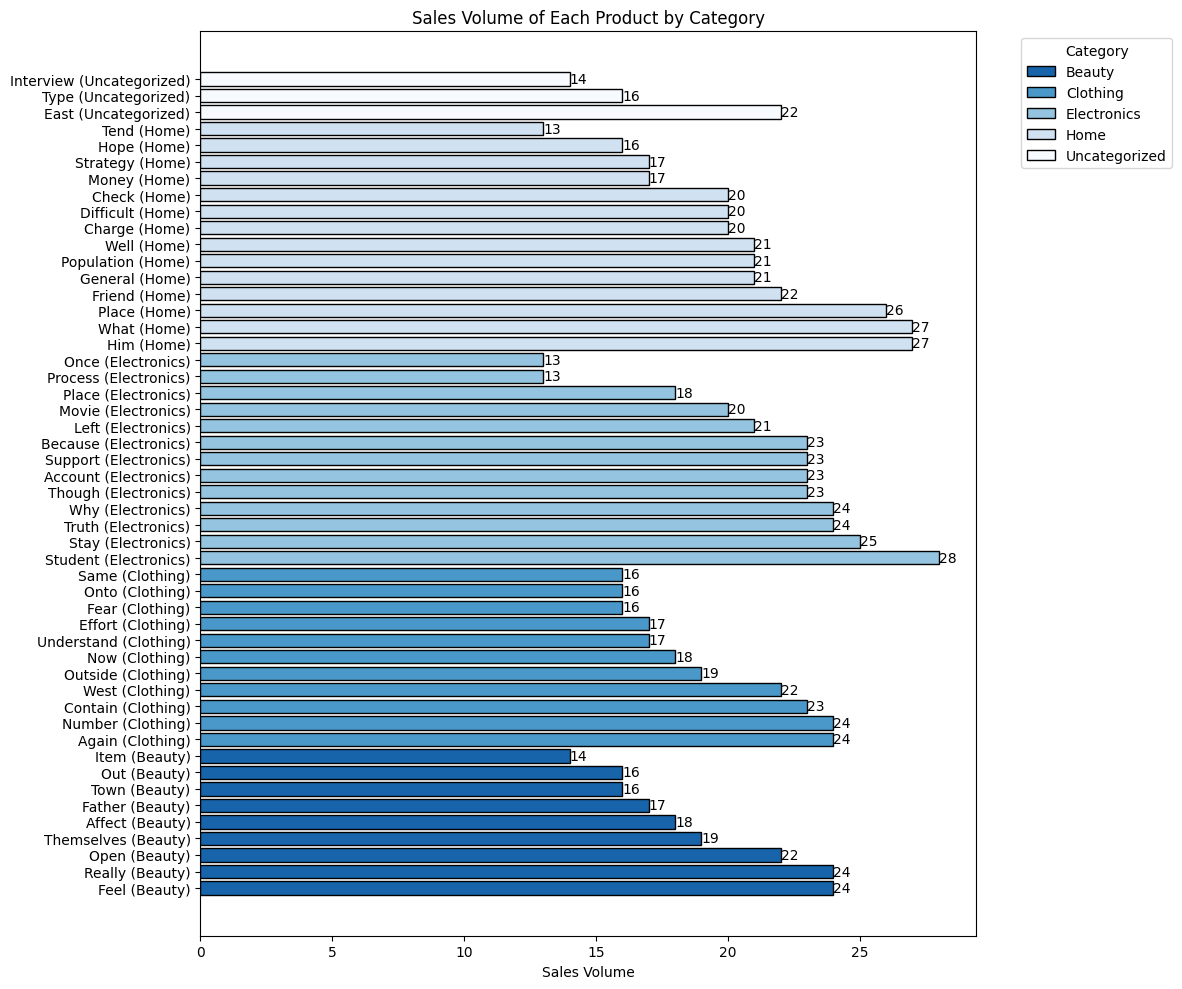

In [9]:
# product_sales_df = product_sales_df.toPandas()

# Sort the DataFrame by 'Category' and then by 'Sales_Volume' within each category
product_sales_df = product_sales_df.sort_values(by=['Category', 'Sales_Volume'], ascending=[True, False])

# Add category information to product names for y-axis labels
product_sales_df['Product_Label'] = product_sales_df['Product_Name'] + ' (' + product_sales_df['Category'] + ')'

# Set up the plotting space
fig, ax = plt.subplots(figsize=(12, 10))

# Get unique categories for color coding
categories = product_sales_df['Category'].unique()

# Define a colormap for shades of blue
cmap = get_cmap('Blues')

# Generate colors for each category
palette = [cmap(i / len(categories)) for i in range(len(categories))][::-1]

# Plot each category
for i, category in enumerate(categories):
    category_data = product_sales_df[product_sales_df['Category'] == category]
    bars = ax.barh(category_data['Product_Label'], category_data['Sales_Volume'], 
                   label=category, color=palette[i], edgecolor='black')

    # Add exact sales volume labels on the bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                va='center', ha='left', fontsize=10, color='black')

# Set labels and title
ax.set_xlabel('Sales Volume')
ax.set_title('Sales Volume of Each Product by Category')
ax.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()

plt.show()


# 3. Total Sales Volume by Product Category

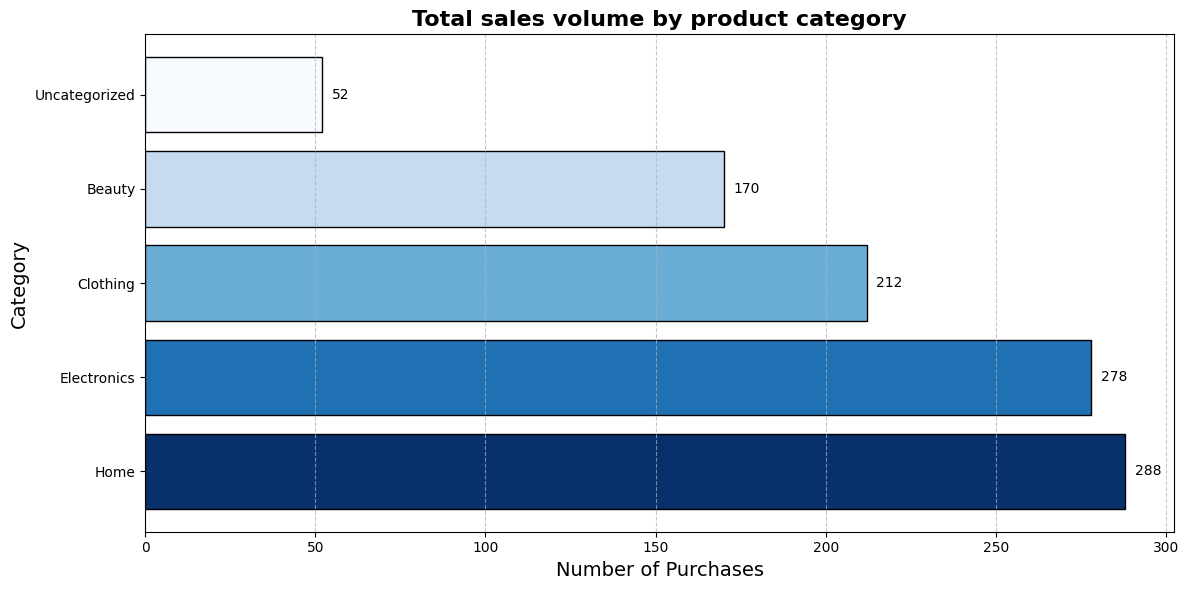

In [10]:
# Join the transactions DataFrame with the products DataFrame on Product_ID
merged_df = transactions_df.join(products_df, on='Product_ID').toPandas()
# Aggregate the number of purchases by product and category
product_purchases = merged_df.groupby(['Product_Name', 'Category']).agg({'Transaction_ID': 'count'}).reset_index()
category_purchases = merged_df.groupby(['Category']).agg({'Transaction_ID': 'count'}).reset_index()

# Rename columns for clarity
product_purchases.rename(columns={'Transaction_ID': 'Purchase_Count'}, inplace=True)
category_purchases.rename(columns={'Transaction_ID': 'Purchase_Count'}, inplace=True)

# Sort by Purchase_Count to get top items
top_products = product_purchases.sort_values(by='Purchase_Count', ascending=False)
top_categories = category_purchases.sort_values(by='Purchase_Count', ascending=False)

# Define a colormap for shades of blue
cmap = get_cmap('Blues')
categories = top_categories['Category'].unique()

# Generate colors based on the unique values
category_colors = cmap(np.linspace(0, 1, len(categories)))[::-1]

# Map the colors to the DataFrame based on category
category_color_dict = dict(zip(categories, category_colors))
top_categories['Color'] = top_categories['Category'].map(category_color_dict)

# Set up the figure and axes
fig, ax2 = plt.subplots(figsize=(12, 6))

# Bar plot for number of purchases by category
bars2 = ax2.barh(top_categories['Category'], top_categories['Purchase_Count'], color=top_categories['Color'], edgecolor='black')
ax2.set_title('Total sales volume by product category', fontsize=16, fontweight='bold')
ax2.set_xlabel('Number of Purchases', fontsize=14)
ax2.set_ylabel('Category', fontsize=14)
ax2.grid(axis='x', linestyle='--', alpha=0.7)

# Add labels on the bars
for bar in bars2:
    xval = bar.get_width()
    ax2.text(
        xval + 0.01 * max(top_categories['Purchase_Count']),
        bar.get_y() + bar.get_height() / 2,
        f'{xval:.0f}',
        va='center',
        ha='left',
        fontsize=10
    )

# Adjust layout
plt.tight_layout()
plt.show()

# 4. Total Revenue by Product Category

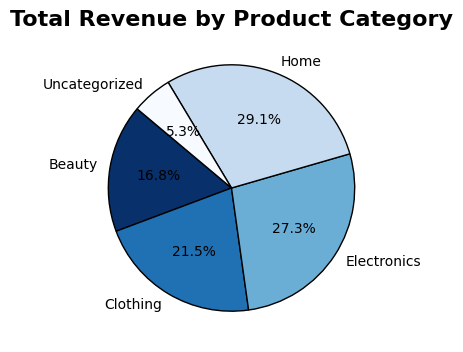

In [ ]:
# Aggregate total spending by category
category_spending = merged_df.groupby(['Category']).agg({'Amount': 'sum'}).reset_index()

# Define a colormap for shades of blue
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(0, 1, len(category_spending)))[::-1]

# Create a pie chart
plt.figure(figsize=(8, 4))
plt.pie(
    category_spending['Amount'], 
    labels=category_spending['Category'], 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Add a title
plt.title('Total Revenue by Product Category', fontsize=16, fontweight='bold')

# Display the pie chart
plt.show()

## 5. Top 20 Products by Total Revenue

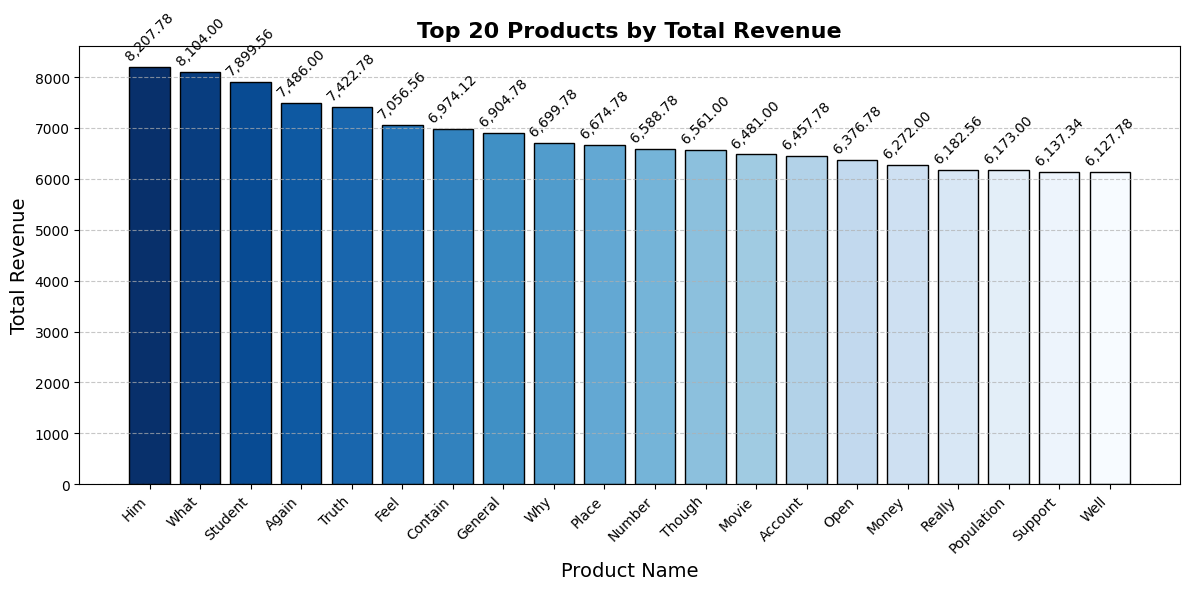

In [12]:
# Sort by Total_Revenue to get the top 10 products
top_products_revenue = product_sales_df.sort_values(by='Total_Revenue', ascending=False).head(20)

# Define a colormap for shades of blue
cmap = get_cmap('Blues')
# Generate colors for the top 10 products
colors = cmap(np.linspace(0, 1, len(top_products_revenue)))[::-1]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for top 10 products by total revenue
bars = ax.bar(top_products_revenue['Product_Name'], top_products_revenue['Total_Revenue'], color=colors, edgecolor='black')
ax.set_title('Top 20 Products by Total Revenue', fontsize=16, fontweight='bold')
ax.set_xlabel('Product Name', fontsize=14)
ax.set_ylabel('Total Revenue', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(top_products_revenue['Total_Revenue']),
        f'{height:,.2f}',
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=45
    )

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()


## 6. Top 20 Products by Sales Volume

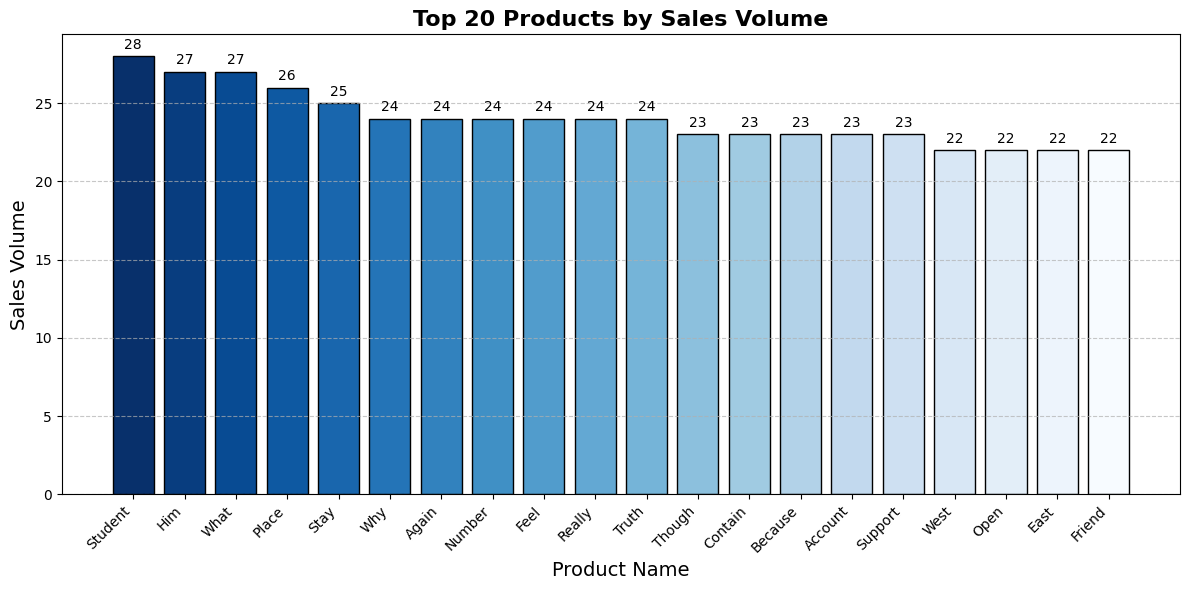

In [13]:
# Sort by Sales_Volume to get the top 10 products
top_products = product_sales_df.sort_values(by='Sales_Volume', ascending=False).head(20)

# Define a colormap for shades of blue
cmap = get_cmap('Blues')
# Generate colors for the top 10 products
colors = cmap(np.linspace(0, 1, len(top_products)))[::-1]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for top 10 products by sales volume
bars = ax.bar(top_products['Product_Name'], top_products['Sales_Volume'], color=colors, edgecolor='black')
ax.set_title('Top 20 Products by Sales Volume', fontsize=16, fontweight='bold')
ax.set_xlabel('Product Name', fontsize=14)
ax.set_ylabel('Sales Volume', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(top_products['Sales_Volume']),
        f'{height:.0f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.show()


## 7. Effect of Pricing on Sales Volume by Category

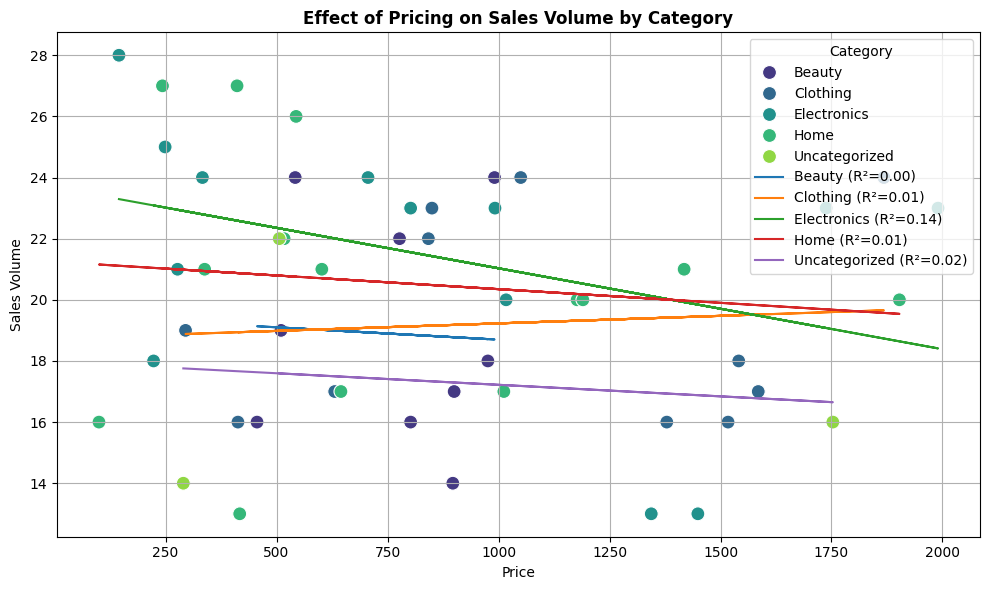

In [14]:
# Scatter plot to visualize the relationship between price and sales volume
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_sales_df, x='Price', y='Sales_Volume', hue='Category', palette='viridis', s=100)

# Fit a linear regression line to see the trend
for category in product_sales_df['Category'].unique():
    cat_data = product_sales_df[product_sales_df['Category'] == category]
    slope, intercept, r_value, p_value, std_err = linregress(cat_data['Price'], cat_data['Sales_Volume'])
    plt.plot(cat_data['Price'], intercept + slope * cat_data['Price'], label=f'{category} (R²={r_value**2:.2f})')

# Title and labels
plt.title('Effect of Pricing on Sales Volume by Category', fontweight= 'bold')
plt.xlabel('Price')
plt.ylabel('Sales Volume')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()

plt.show()

# 8. Category Performance by Total Revenue

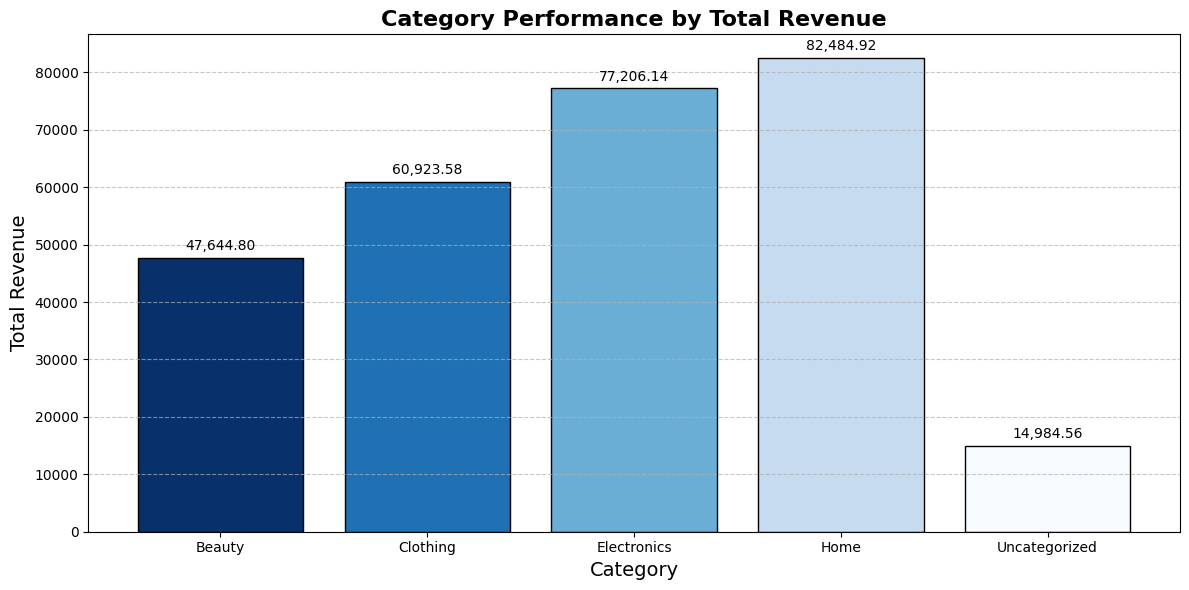

In [ ]:
# Evaluate Category Performance by Total Revenue
category_performance = product_sales_df.groupby('Category').agg({
    'Total_Revenue': 'sum',
    'Sales_Volume': 'sum'
}).reset_index()

# Define a colormap for shades of blue
cmap = get_cmap('Blues')

# Generate colors for the categories
colors = cmap(np.linspace(0, 1, len(category_performance)))[::-1]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for Category Performance by Total Revenue
bars = ax.bar(category_performance['Category'], category_performance['Total_Revenue'], color=colors, edgecolor='black')

# Customize the title and labels
ax.set_title('Category Performance by Total Revenue', fontsize=16, fontweight='bold')
ax.set_xlabel('Category', fontsize=14)
ax.set_ylabel('Total Revenue', fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(category_performance['Total_Revenue']),
        f'{height:,.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Adjust layout
plt.tight_layout()
plt.show()